In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

# 資料前處理

In [2]:
category_index = pd.read_excel('data/類型代號說明.xlsx', '網頁版')
category_dict = dict(category_index.iloc[:, :2].values)
category_index.head()

,類別代號,中文名稱,英文名稱,說明
0,AA1,國內投資股票型,Domestic Equity Fund,NaN
1,AA2,跨國投資股票型,International Equity Fund,NaN
2,AB1,國內投資平衡型,Domestic Balanced Fund,NaN
3,AB2,跨國投資平衡型,International Balanced Fund,NaN
4,AC12,國內投資固定收益一般債券型,Domestic Fixed-income Fund,NaN


In [3]:
data = pd.read_csv('data/data.csv',thousands=',')

# drop nan
data = data[data.類型代號.isna() != True]

# 處理AI, AH代碼問題
data.loc[data[data.基金統編 == '99346928'].index, '類型代號'] = 'AI1'
data.loc[data[data.基金統編 == '25591306'].index, '類型代號'] = 'AI2'
data.loc[data[data.基金統編 == '25610486'].index, '類型代號'] = 'AH2'
data.loc[data.基金統編.isin(data[data.類型代號 == 'AH'].基金統編.unique()), '類型代號'] = 'AH1'

def transform_key(x):
    try:
        return category_dict[x]
    except:
        pass

# 轉換代碼
data['基金類型'] = data.類型代號.apply(lambda x: transform_key(x))

# 剔除沒有基金類型者(各家每年總和值)
data = data[data.基金類型.isna() != True]

# 轉換年分
data.年分 = data.年分.apply(lambda x: datetime.strptime(str(x)[:4]+'/12/31', '%Y/%m/%d'))

# 存year index
year_index = np.arange(2008, 2019, 1)

In [4]:
category_index = pd.read_excel('data/類型代號說明.xlsx', '網頁版')
category_dict = dict(category_index.iloc[:, :2].values)
category_index.head(1)

# 建立大分類
main_category = dict({
    '股票型': set(['AA1', 'AA2']),
    '平衡型': set(['AB1', 'AB2']),
    '債券與金融資產證券化型': set(['AC12', 'AC21', 'AC22', 'AC23']),
    '貨幣市場型': set(['AD1', 'AD2', 'AC11']),
    '組合型': set(['AE1', 'AE21', 'AE22', 'AE23', 'AE24']),
    '保本型': set(['AF']),
    '不動產證券化型': set(['AG']),
    '指數股票型': set(['AH1', 'AH2']),
    '指數型': set(['AI1', 'AI2']),
    '多重資產型': set(['AJ1', 'AJ2']),
#     '類貨幣市場型': set(['AC11']),
    '私募基金': set(['B'])
})

for key in main_category.keys():
    index = data.類型代號.apply(lambda x: x in main_category[key])
    data.loc[index, '大分類'] = key

data.head()

,類型代號,計價幣別,基金統編,基金名稱,基金規模(台幣),基金規模市場占有率,單位淨值(台幣),受益權單位數,自然人受益人數,法人受益人數,總受益人數,本年申購總金額(台幣),本年買回總金額(台幣),年分,基金類型,大分類
2,AA1,TWD,00965469,兆豐國際第一基金,8.781298e+08,0.06%,7.06,1.243438e+08,1290.0,35.0,1325.0,6.152298e+08,8.292591e+08,2008-12-31,國內投資股票型,股票型
3,AB1,TWD,00971976,兆豐國際萬全基金,3.765004e+08,0.02%,9.74,3.863819e+07,2107.0,20.0,2127.0,1.368018e+08,1.373652e+08,2008-12-31,國內投資平衡型,平衡型
4,AA2,TWD,00992769,兆豐國際全球基金,1.403546e+09,0.09%,22.86,6.140483e+07,7052.0,27.0,7079.0,3.460061e+08,6.802632e+08,2008-12-31,跨國投資股票型,股票型
5,AA1,TWD,01050148,兆豐國際國民基金,4.674497e+08,0.03%,15.47,3.021328e+07,1712.0,25.0,1737.0,1.112234e+08,1.640262e+08,2008-12-31,國內投資股票型,股票型
6,AA1,TWD,10341837,兆豐國際豐台灣基金,2.654048e+08,0.02%,10.28,2.581519e+07,2820.0,34.0,2854.0,1.180153e+09,1.089020e+09,2008-12-31,國內投資股票型,股票型


# 各基金類別資料筆數(大分類)

In [5]:
groupby_big_category = data.groupby(['大分類', '年分']).sum()['基金規模(台幣)'].reset_index()
groupby_big_category.groupby('大分類').count()

,年分,基金規模(台幣)
大分類,,
不動產證券化型,11,11
保本型,7,7
債券與金融資產證券化型,11,11
多重資產型,2,2
平衡型,11,11
指數型,11,11
指數股票型,11,11
組合型,11,11
股票型,11,11


# 各類別(大類別)基金各年AUM概況(已依據2018年之AUM排序)
# 沒有sub bar

In [6]:
# 依據最新資料排序市值
result = pd.DataFrame([])
for name in groupby_big_category.大分類.unique():
    target = groupby_big_category[groupby_big_category.大分類 == name].iloc[-1, :]
    if target.年分.year == 2018:
        value = target['基金規模(台幣)']
    else:
        value = 0
    temp_result = pd.DataFrame([[name, value]])
    result = pd.concat([result, temp_result])
    
result.columns = ['big_category', 'value']
big_category_order = result.sort_values('value', ascending=False)['big_category']

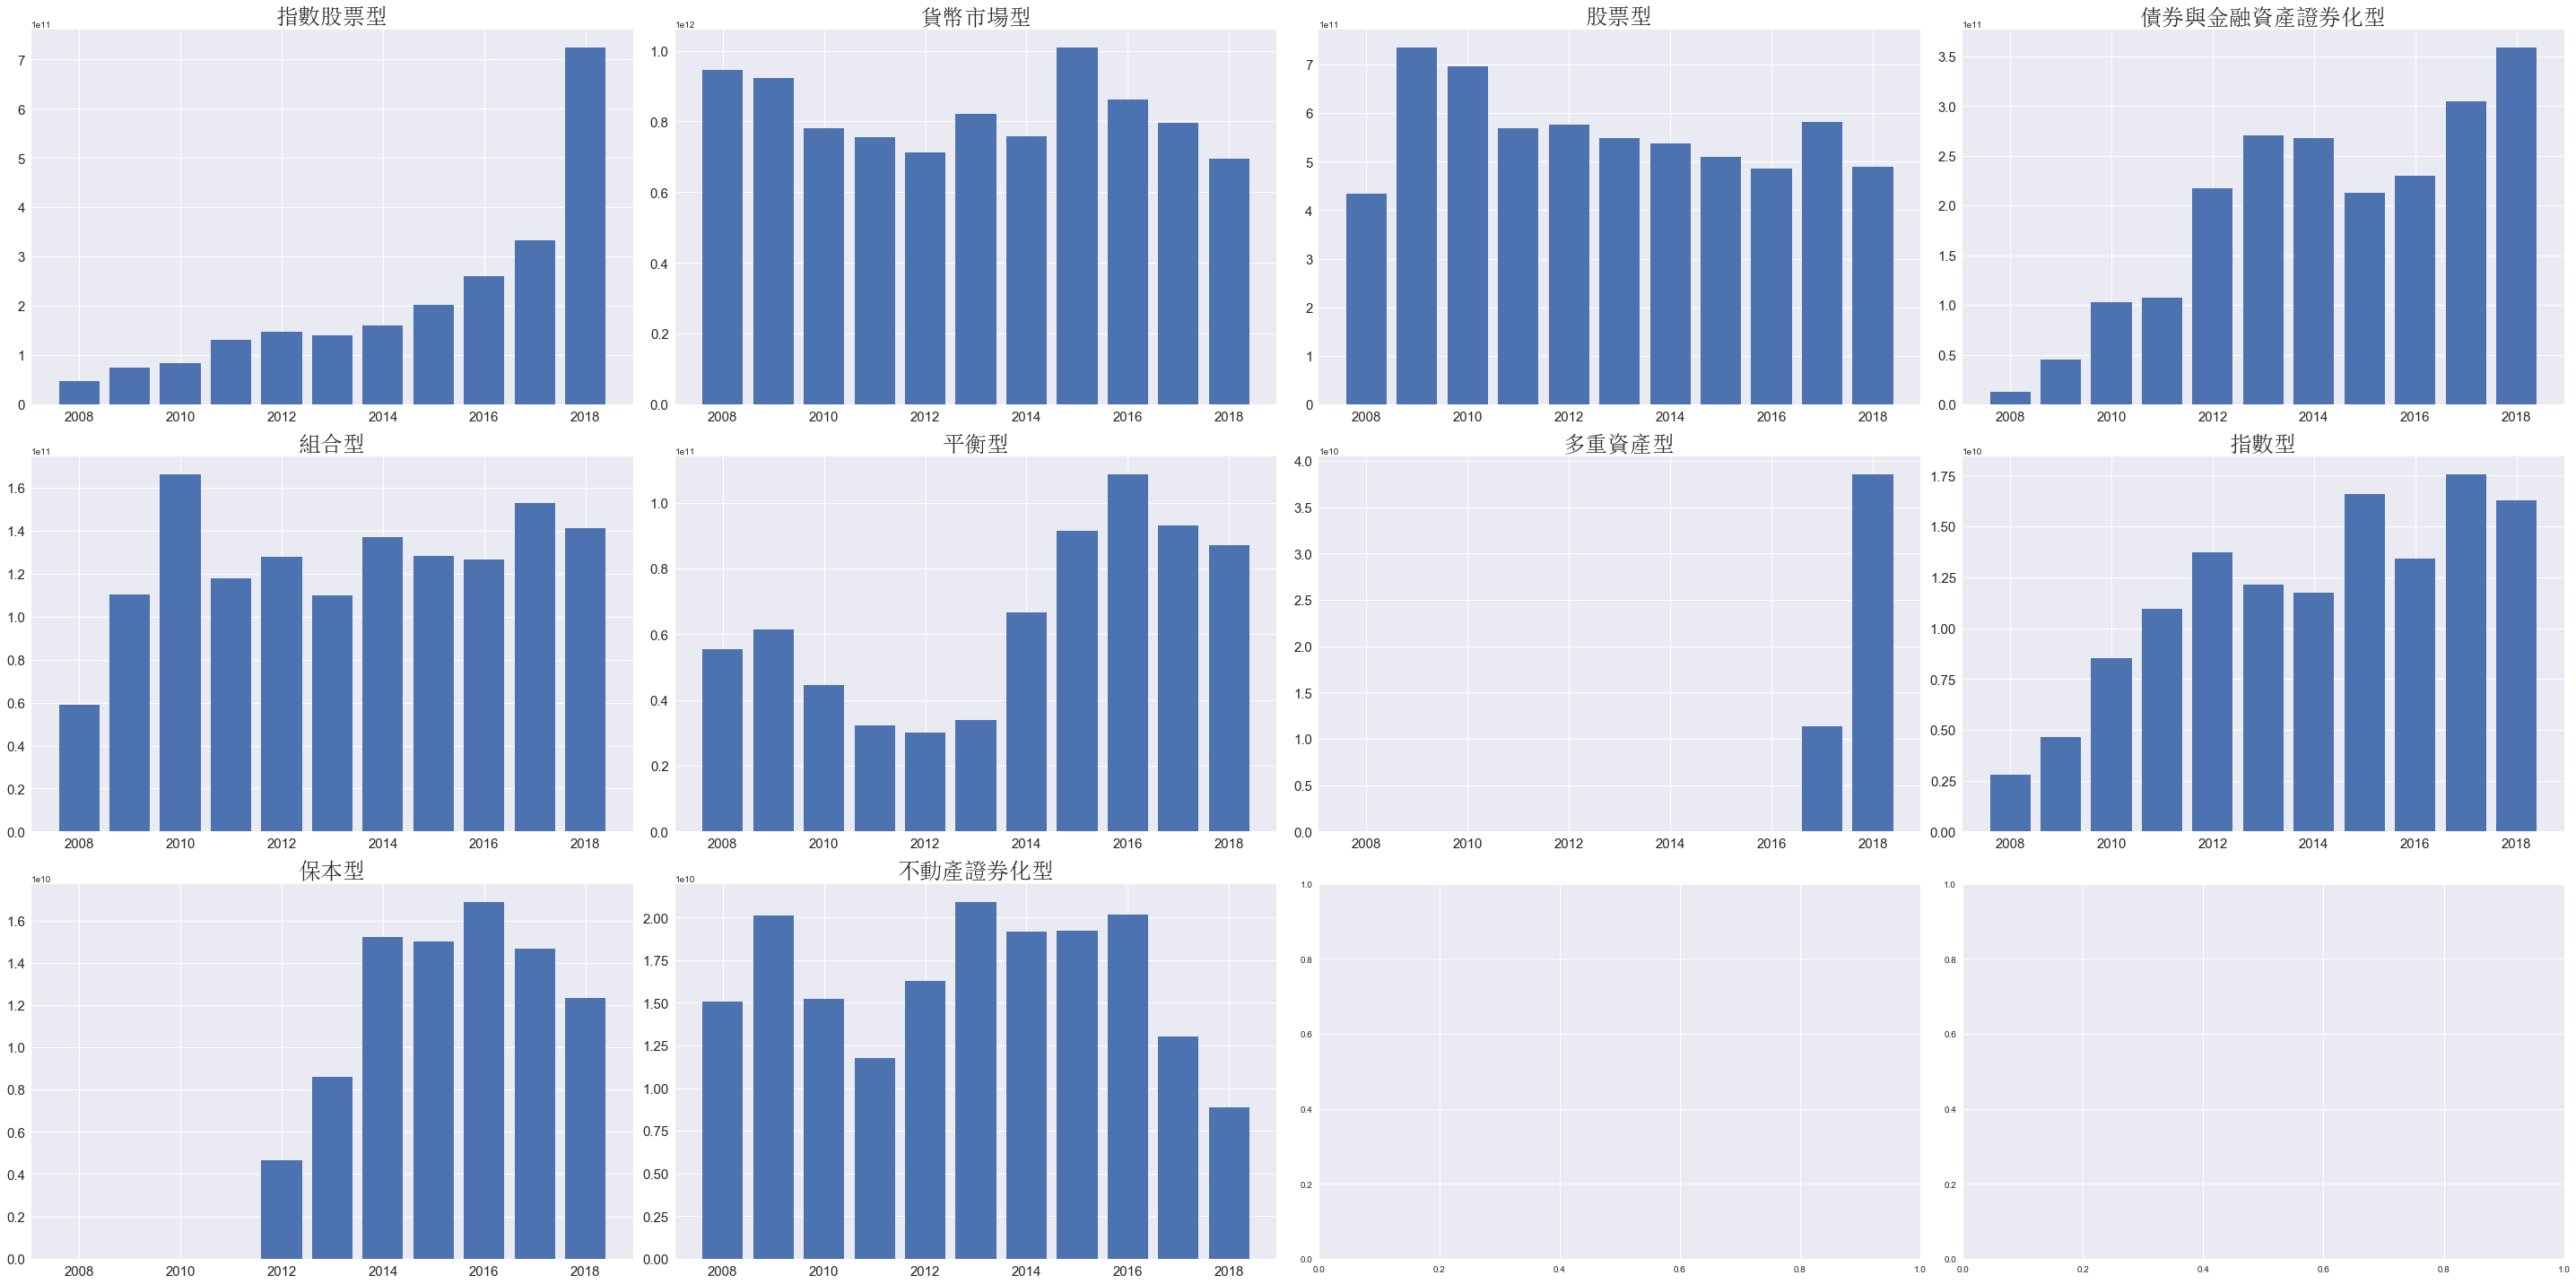

In [7]:
from matplotlib.font_manager import FontProperties
font = FontProperties(fname=r"c:\windows\Fonts\SimSun.ttc", size=25)

plt.style.use('seaborn')
fig, axs = plt.subplots(3, 4, figsize=(40, 20))
axs = axs.ravel()

for i in range(len(big_category_order)):
    name = big_category_order.iloc[i]
    temp = groupby_big_category[groupby_big_category.大分類 == name]
    temp.reset_index(inplace=True, drop=True)
    temp = temp.copy()
    temp['year'] = temp.年分.apply(lambda x: x.year)
    Y= []
    for ix in year_index:
        try:
            value = temp[temp.year == ix]['基金規模(台幣)'].values[0]
            if value != 0:
                Y.append(value)
            else:
                Y.append(0)
        except:
            Y.append(0)

    plt.sca(axs[i])
    axs[i].bar(year_index, Y)
    axs[i].set_title(name, FontProperties=font)
    plt.xticks(size=15)
    plt.yticks(size=15)
#     if i > len(big_category_order) - 2:
#         fig.delaxes(axs[i+1])

    plt.tight_layout();

# 各類別(大類別)基金各年AUM概況(已依據2018年之AUM排序)，使用相同y軸scale，可以看出規模差異(幾乎看不見者代表規模相對規模大者來的小)
# 沒有sub bar

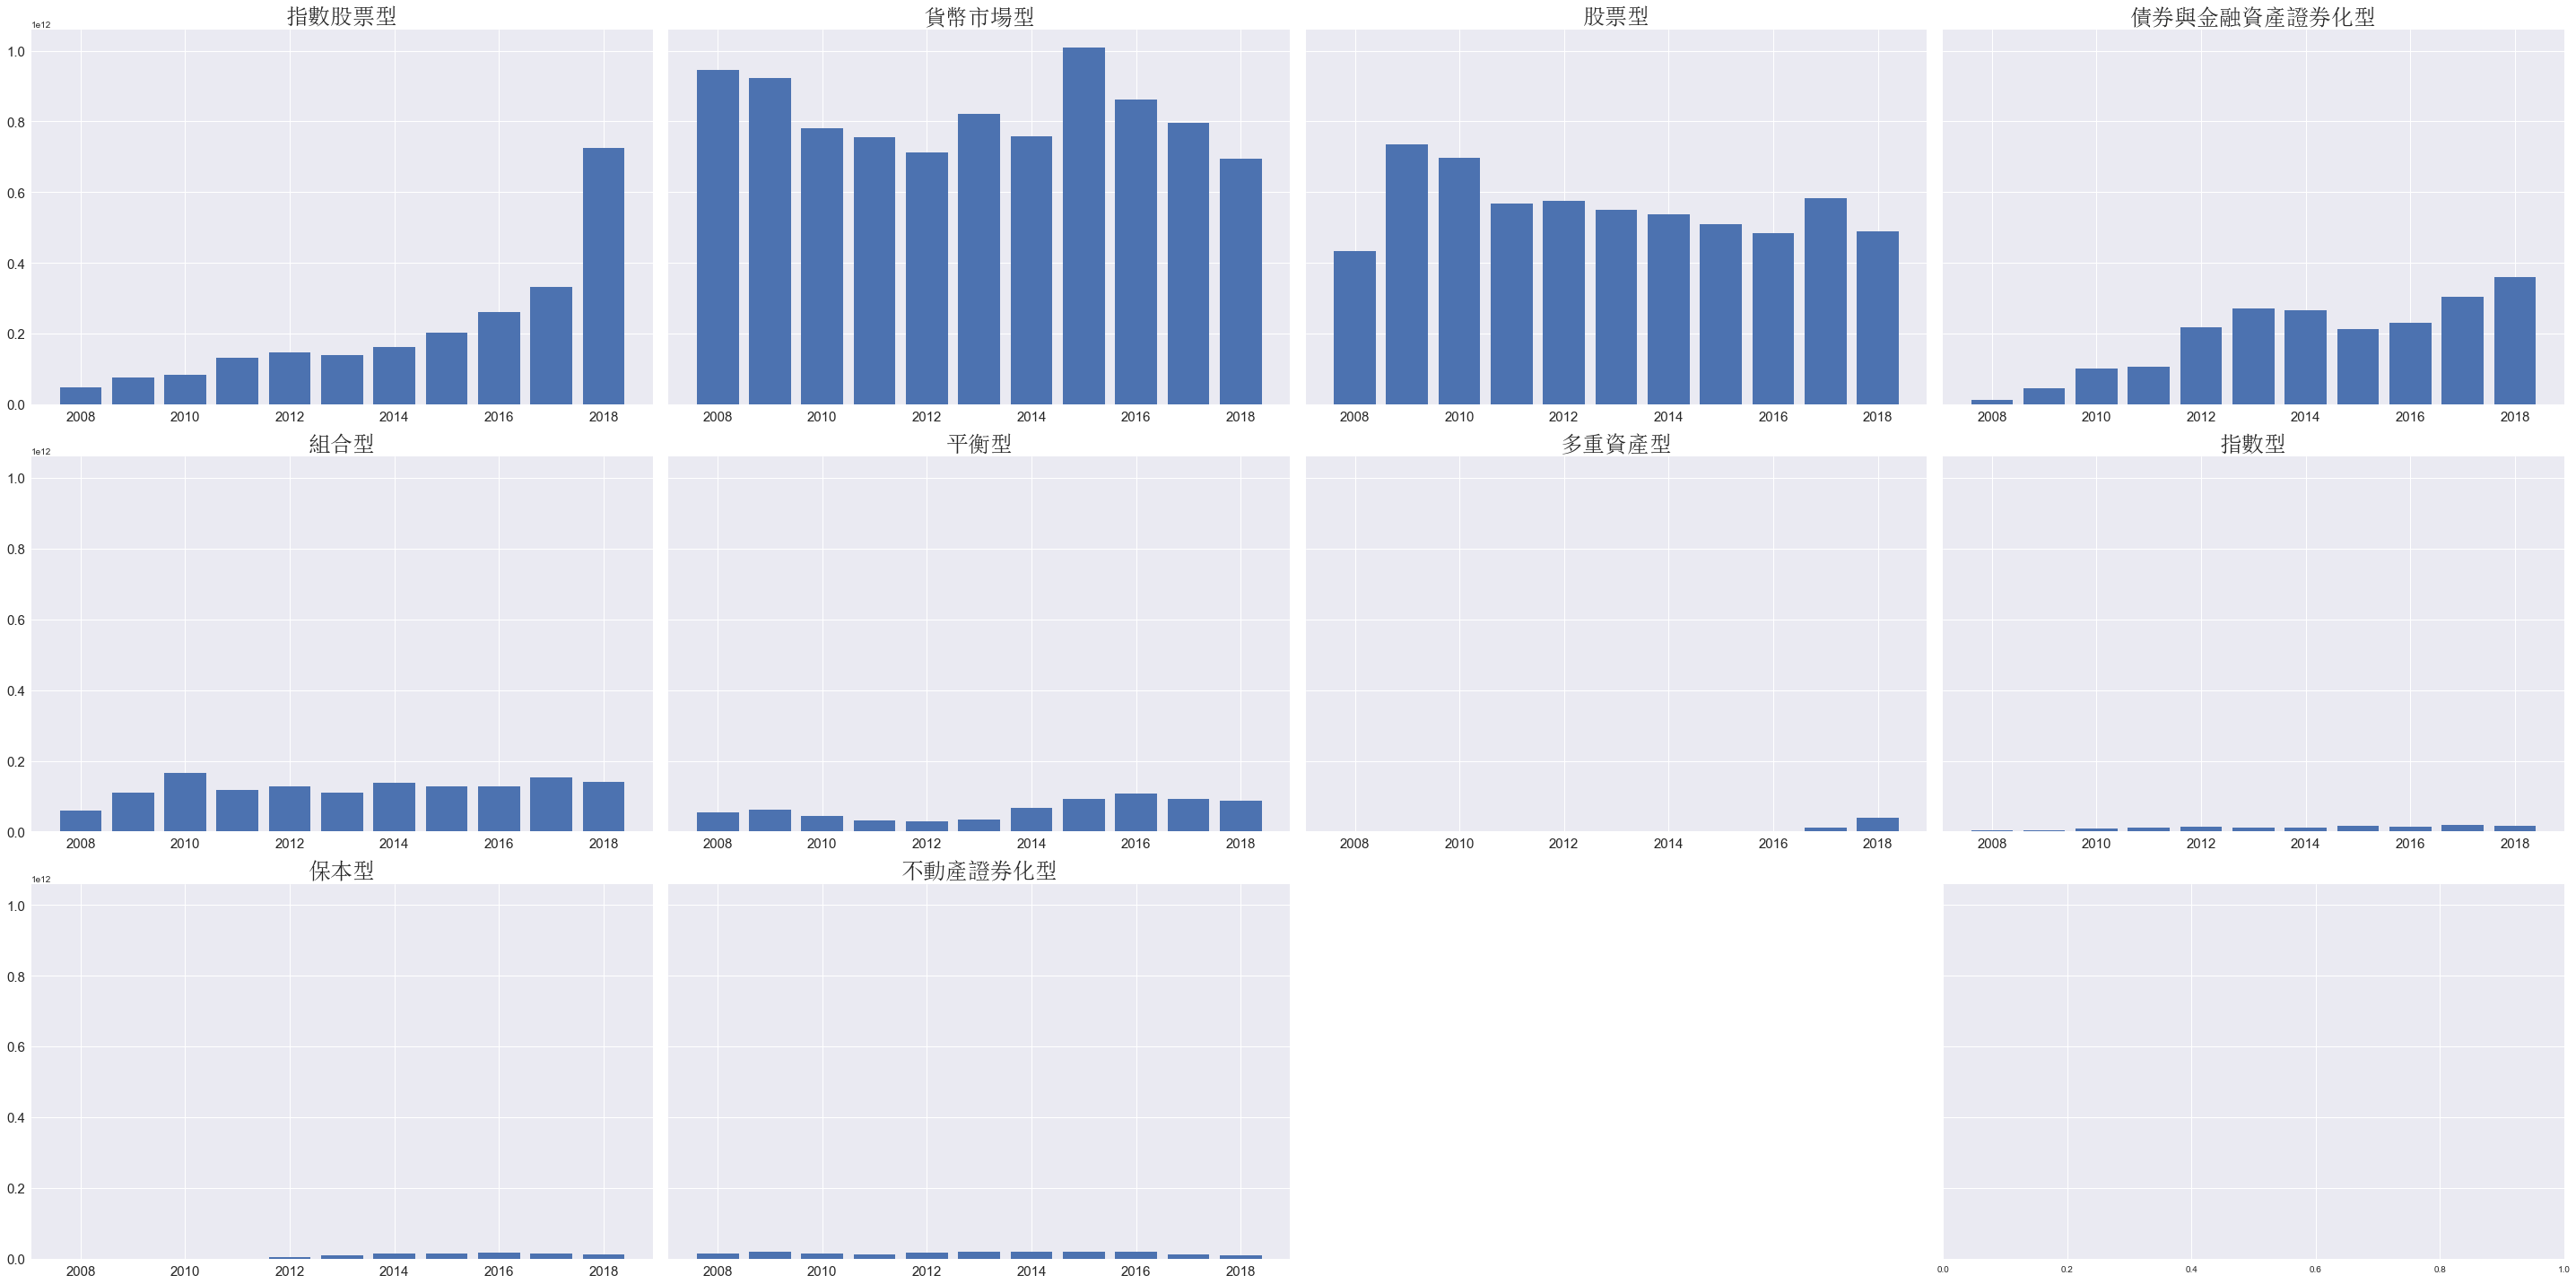

In [8]:
fig, axs = plt.subplots(3, 4, figsize=(40, 20), sharey=True)
axs = axs.ravel()

for i in range(len(big_category_order)):
    name = big_category_order.iloc[i]
    temp = groupby_big_category[groupby_big_category.大分類 == name]
    temp.reset_index(inplace=True, drop=True)
    temp = temp.copy()
    temp['year'] = temp.年分.apply(lambda x: x.year)
    Y = []
    for ix in year_index:
        try:
            value = temp[temp.year == ix]['基金規模(台幣)'].values[0]
            if value != 0:
                Y.append(value)
            else:
                Y.append(0)
        except:
            Y.append(0)

    plt.sca(axs[i])
    axs[i].bar(year_index, Y)
    axs[i].set_title(name, FontProperties=font)
    plt.xticks(size=15)
    plt.yticks(size=15)
    if i == len(big_category_order) - 1:
        fig.delaxes(axs[i+1])

    plt.tight_layout();

# 各類別(大類別)基金各年AUM概況(已依據2018年之AUM排序)
# Stacked bar plot

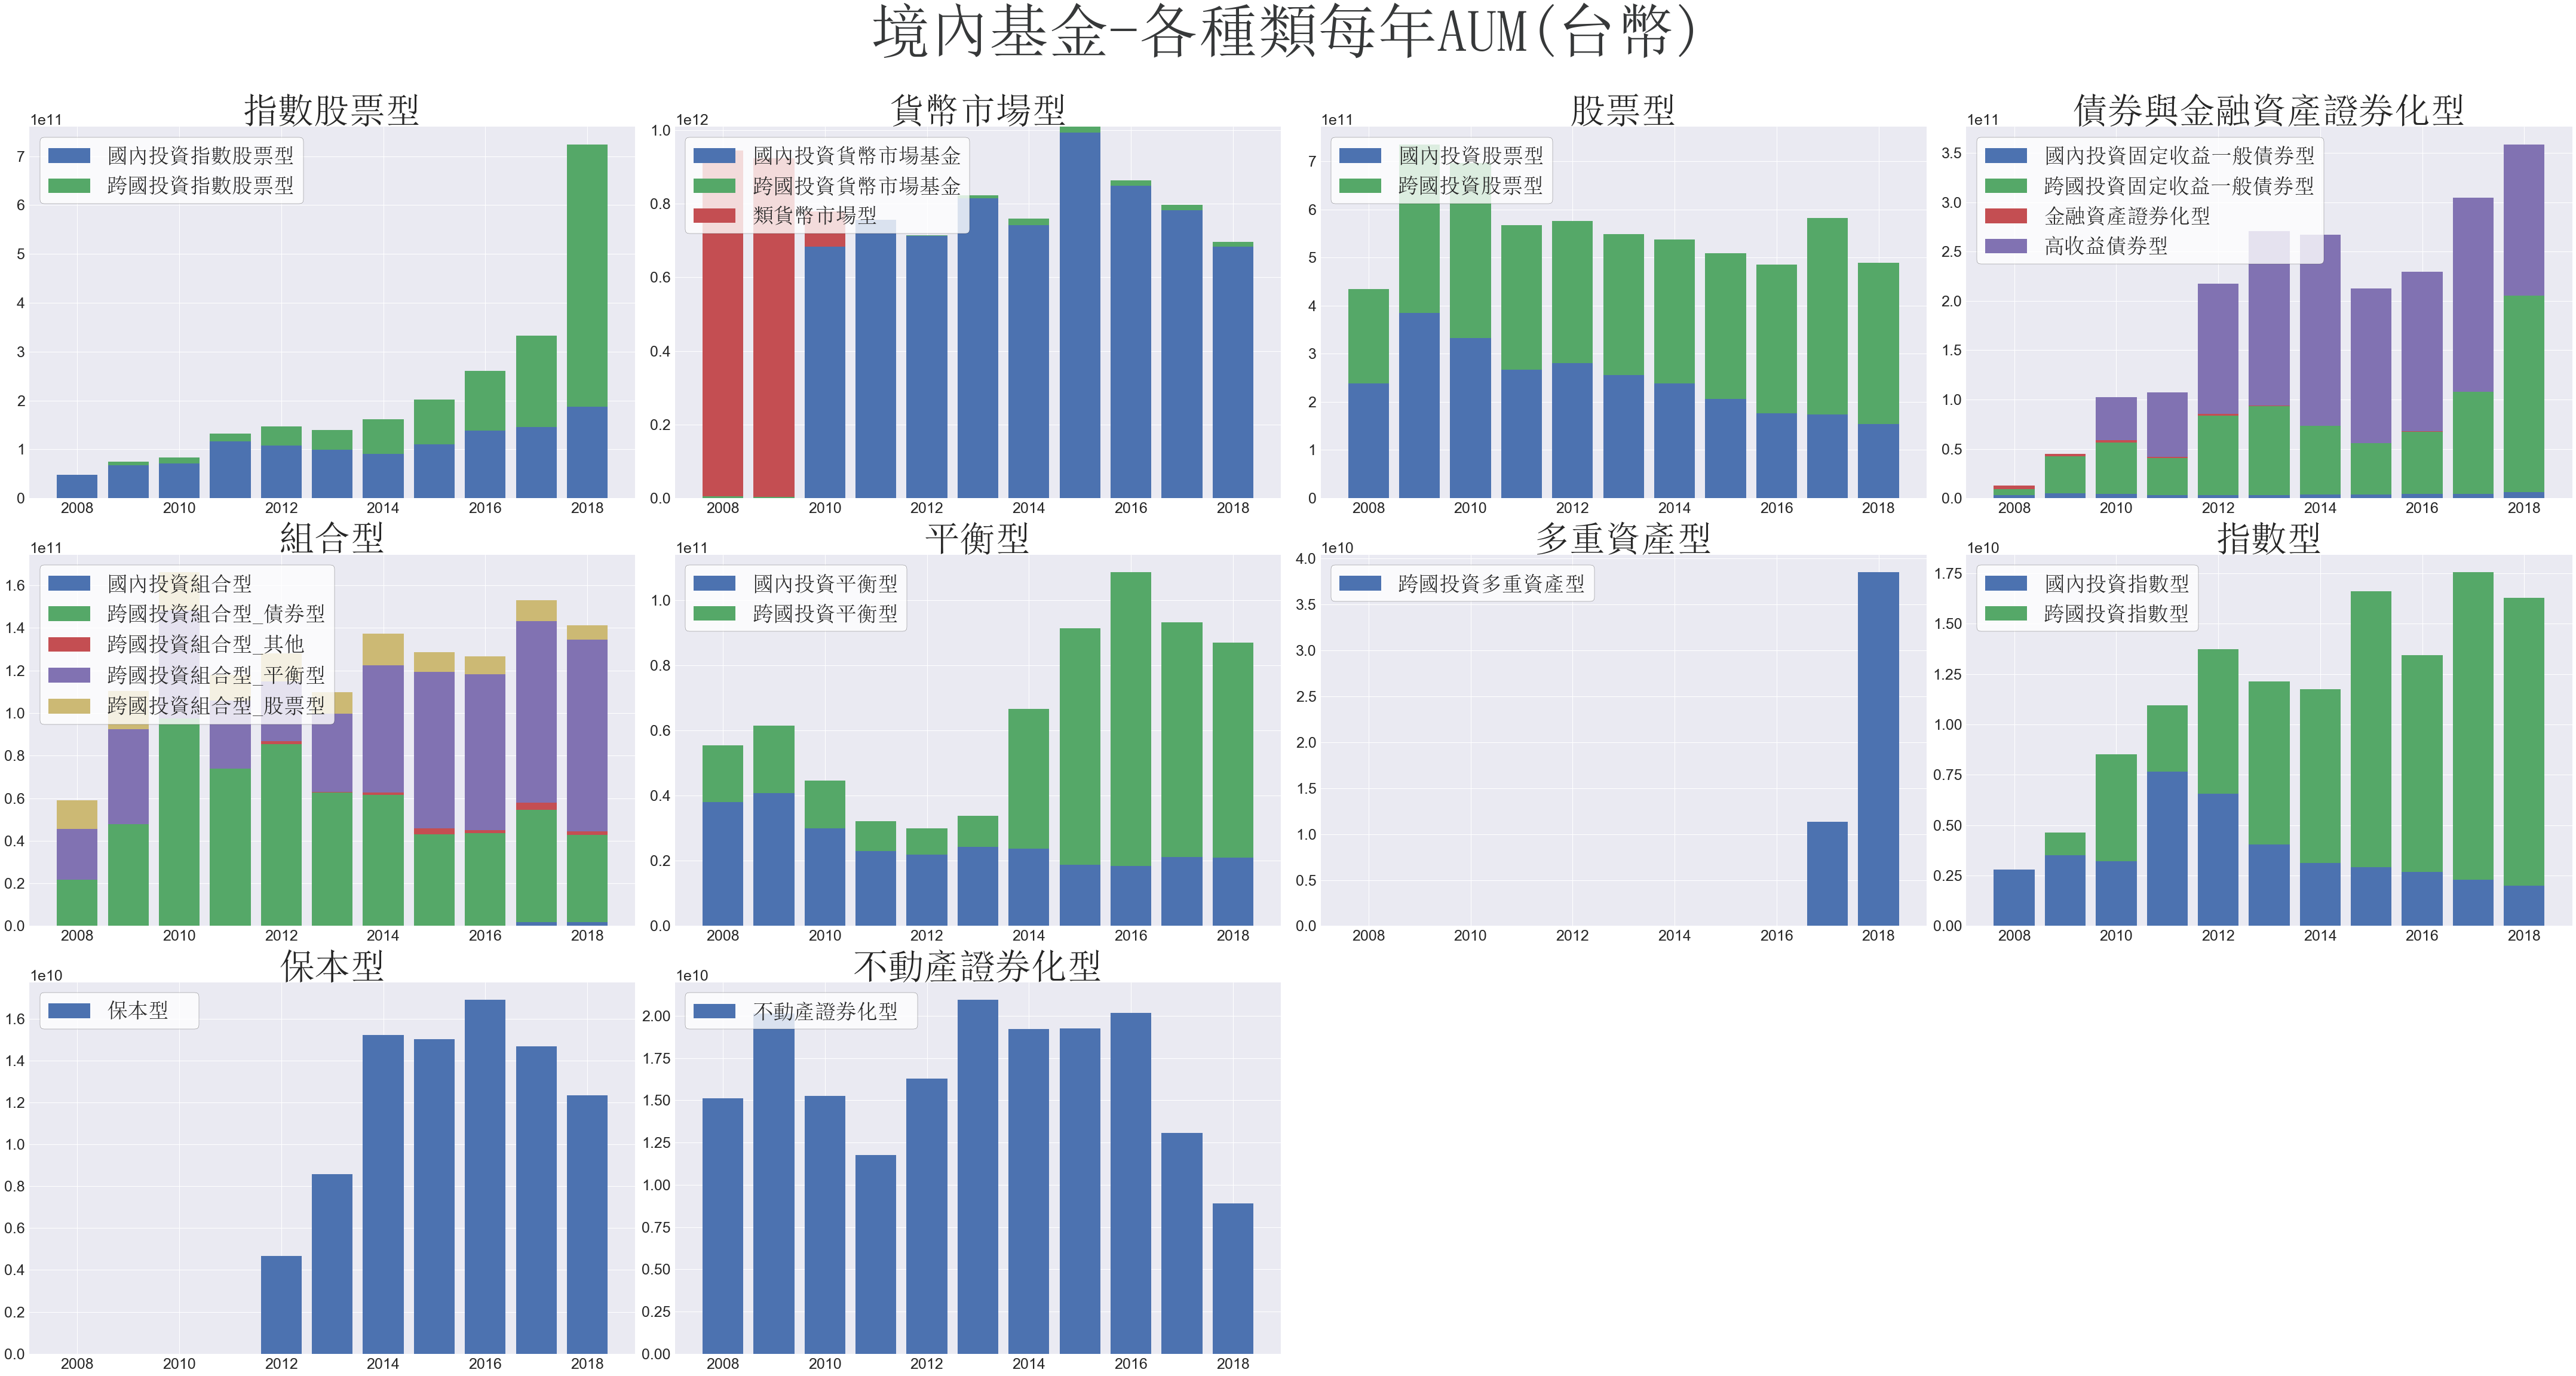

In [9]:
from matplotlib.font_manager import FontProperties
font = FontProperties(fname=r"c:\windows\Fonts\SimSun.ttc", size=60)
font_legend = FontProperties(fname=r"c:\windows\Fonts\SimSun.ttc", size=35)
font_title = FontProperties(fname=r"c:\windows\Fonts\SimSun.ttc")

plt.style.use('seaborn')
fig, axs = plt.subplots(3, 4, figsize=(60, 30))
fig.suptitle("境內基金-各種類每年AUM(台幣)", FontProperties=font_title, fontsize=100, y=1.065,
             color='#363839')
axs = axs.ravel()

for i in range(len(big_category_order)):
    name = big_category_order.iloc[i]    
    target = data[data.大分類 == name]
    target = target.groupby(['基金類型', '年分']).sum()
    target.reset_index(inplace=True)
    target = target[['基金類型', '年分', '基金規模(台幣)']]
    plt.sca(axs[i])
    
    cumulative_Y = np.array([0]*len(year_index))
    for ixx in range(len(target.基金類型.unique())):
        fund = target.基金類型.unique()[ixx]
        temp_fund = target[target.基金類型 == fund]
        temp_fund = temp_fund.copy()
        temp_fund['year'] = temp_fund.年分.apply(lambda x: x.year)
        Y = []
        for ix in year_index:
            try:
                value = temp_fund[temp_fund.year == ix]['基金規模(台幣)'].values[0]
                if value != 0:
                    Y.append(value)
                else:
                    Y.append(0)
            except:
                Y.append(0)
        Y = np.array(Y)

        axs[i].bar(year_index, Y, bottom=cumulative_Y, label=fund)
        cumulative_Y = cumulative_Y + Y

    legend = plt.legend(prop=font_legend, frameon=True, loc='upper left')
    frame = legend.get_frame()
    frame.set_facecolor('white')
    frame.set_edgecolor('black')
    
    axs[i].set_title(name, FontProperties=font)
    axs[i].yaxis.offsetText.set_fontsize(25)
    plt.xticks(size=25)
    plt.yticks(size=25)
    if i == len(big_category_order) - 1:
        fig.delaxes(axs[i+1])
        fig.delaxes(axs[i+2])

    plt.tight_layout();

# 各類別(大類別)基金各年AUM概況(已依據2018年之AUM排序)，使用相同y軸scale，可以看出規模差異(幾乎看不見者代表規模相對規模大者來的小)
# Stacked bar plot

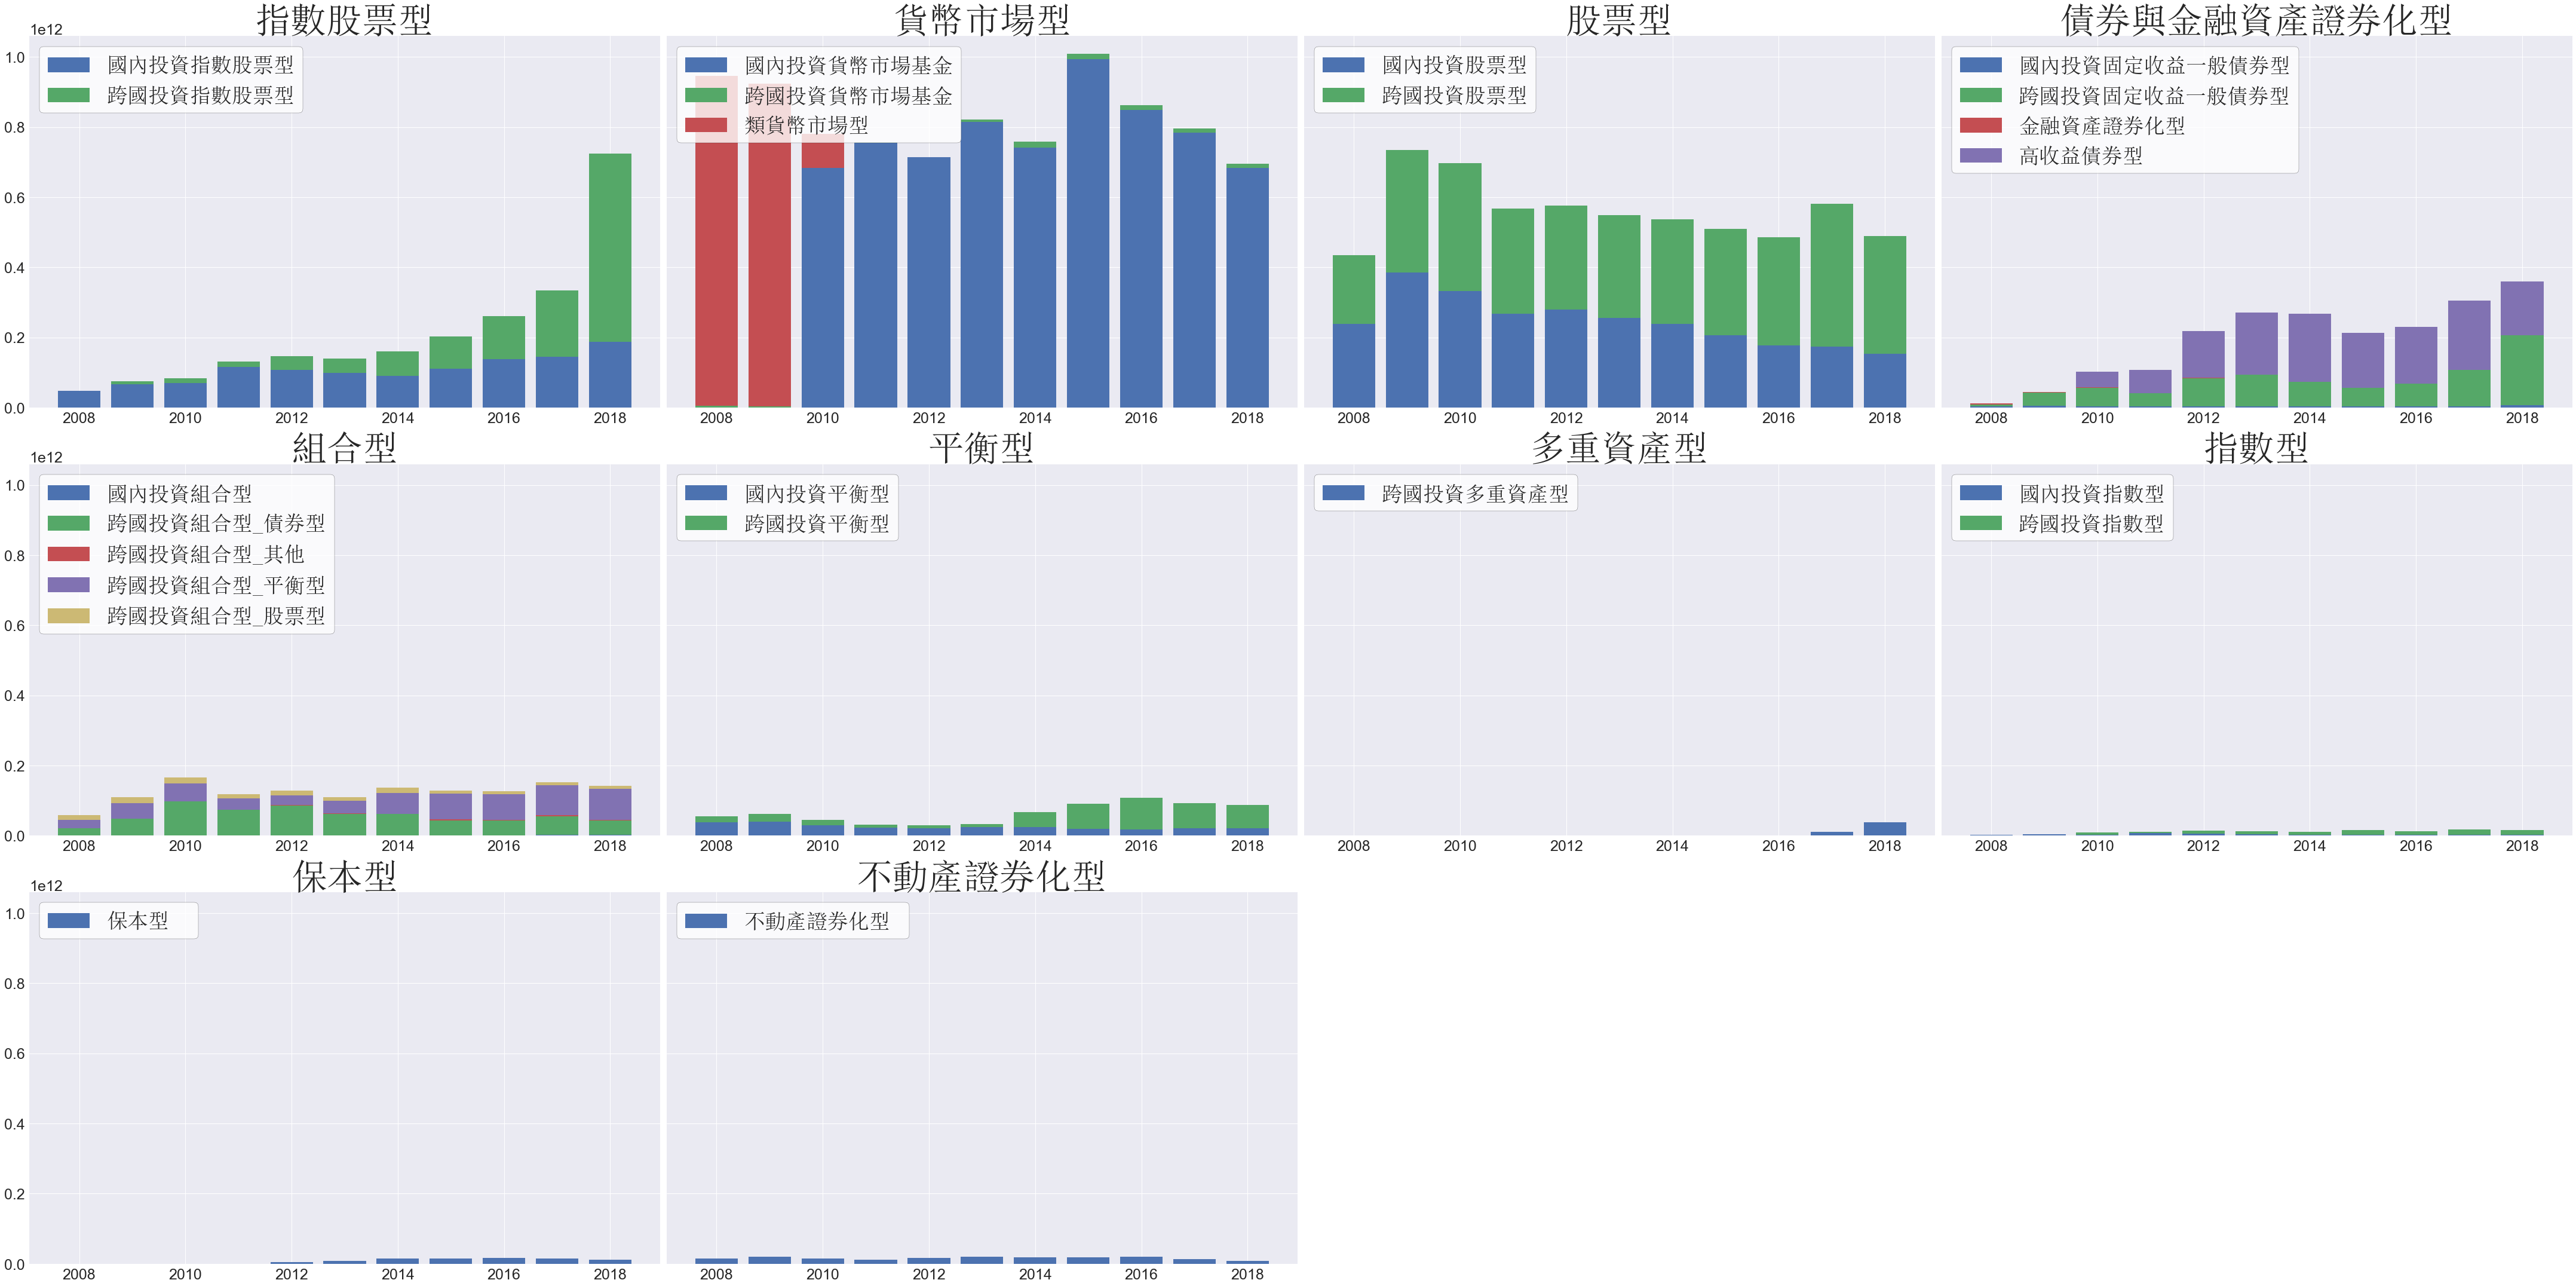

In [10]:
from matplotlib.font_manager import FontProperties
font = FontProperties(fname=r"c:\windows\Fonts\SimSun.ttc", size=60)
font_legend = FontProperties(fname=r"c:\windows\Fonts\SimSun.ttc", size=35)

plt.style.use('seaborn')
fig, axs = plt.subplots(3, 4, figsize=(60, 30), sharey=True)
axs = axs.ravel()

for i in range(len(big_category_order)):
    name = big_category_order.iloc[i]    
    target = data[data.大分類 == name]
    target = target.groupby(['基金類型', '年分']).sum()
    target.reset_index(inplace=True)
    target = target[['基金類型', '年分', '基金規模(台幣)']]
    plt.sca(axs[i])
    
    cumulative_Y = np.array([0]*len(year_index))
    for ixx in range(len(target.基金類型.unique())):
        fund = target.基金類型.unique()[ixx]
        temp_fund = target[target.基金類型 == fund]
        temp_fund = temp_fund.copy()
        temp_fund['year'] = temp_fund.年分.apply(lambda x: x.year)
        Y = []
        for ix in year_index:
            try:
                value = temp_fund[temp_fund.year == ix]['基金規模(台幣)'].values[0]
                if value != 0:
                    Y.append(value)
                else:
                    Y.append(0)
            except:
                Y.append(0)
        Y = np.array(Y)

        axs[i].bar(year_index, Y, bottom=cumulative_Y, label=fund)
        cumulative_Y = cumulative_Y + Y

    legend = plt.legend(prop=font_legend, frameon=True, loc='upper left')
    frame = legend.get_frame()
    frame.set_facecolor('white')
    frame.set_edgecolor('black')
    
    axs[i].set_title(name, FontProperties=font)
    axs[i].yaxis.offsetText.set_fontsize(25)
    plt.xticks(size=25)
    plt.yticks(size=25)
    if i == len(big_category_order) - 1:
        fig.delaxes(axs[i+1])
        fig.delaxes(axs[i+2])

    plt.tight_layout();

# 成長率-Heatmap

In [11]:
groupby_big_category_wtih_growth = pd.DataFrame([])
for fund in groupby_big_category.大分類.unique():
    temp = groupby_big_category[groupby_big_category.大分類 == fund]
    growth = (temp['基金規模(台幣)'] - temp['基金規模(台幣)'].shift())/temp['基金規模(台幣)'].shift()
    temp = temp.copy()
    temp['growth_rate'] = growth
    
    growth.dropna(inplace=True)
    gemotric_rate = pow(
        np.cumprod((growth.values + 1))[-1],
        1/len(growth)
    ) - 1
    
    temp['gemotric_rate'] = gemotric_rate
    
    groupby_big_category_wtih_growth = pd.concat([
        groupby_big_category_wtih_growth,
        temp
    ])

In [12]:
name_list = groupby_big_category_wtih_growth.大分類.unique()
result = pd.DataFrame([], columns=range(len(name_list)), index=year_index)
for i in range(len(name_list)):
    name = name_list[i]
    temp = groupby_big_category_wtih_growth[groupby_big_category_wtih_growth.大分類 == name]
    temp = temp.copy()
    temp['year'] = temp.年分.apply(lambda x: x.year)
    for ix in range(len(year_index)):
        temp_year = year_index[ix]
        try:
            result.iloc[ix, i] = temp[temp.year == temp_year]['growth_rate'].values[0]
        except:
            result.iloc[ix, i] = 0
            
result.columns = name_list
result = result.fillna(0)
result = result.iloc[1:, ]
result = result.T
result.columns = list(map(lambda x: str(x), np.arange(2009, 2019, 1)))
result.sort_values('2018', ascending=False, inplace=True)

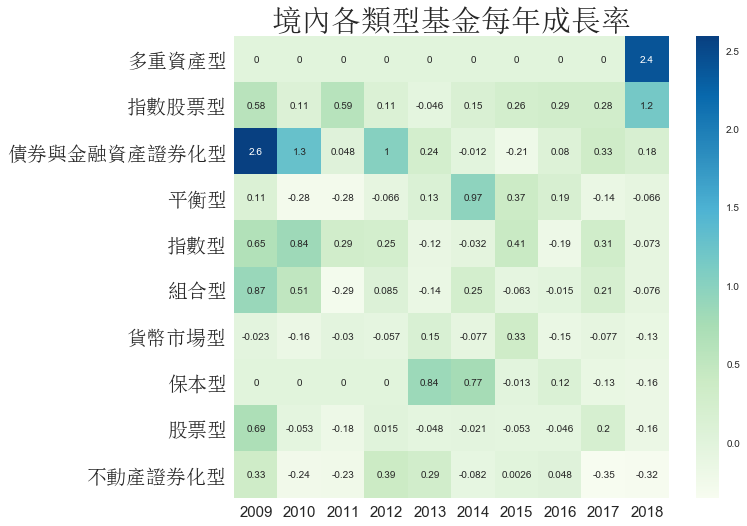

In [13]:
import seaborn as sns
from matplotlib import cm
from matplotlib.font_manager import FontProperties
font = FontProperties(fname=r"c:\windows\Fonts\SimSun.ttc", size=20)

plt.figure(figsize=(11, 7))
ax = sns.heatmap(result, annot=True, cmap=cm.GnBu) # , fmt="d"
ax.set_xticklabels(np.arange(2009, 2019, 1), size=15)
ax.set_yticklabels(result.index, fontproperties=font)
plt.tight_layout()

font_title = FontProperties(fname=r"c:\windows\Fonts\SimSun.ttc", size=30)
plt.title('境內各類型基金每年成長率', FontProperties=font_title);

In [14]:
gemotric_rate = groupby_big_category_wtih_growth[groupby_big_category_wtih_growth.年分 == '2018-12-31']
gemotric_rate = gemotric_rate.copy()
gemotric_rate.sort_values('gemotric_rate', ascending=False, inplace=True)
gemotric_rate

,大分類,年分,基金規模(台幣),growth_rate,gemotric_rate
30,多重資產型,2018-12-31,3.851032e+10,2.392912,2.392912
28,債券與金融資產證券化型,2018-12-31,3.588717e+11,0.178535,0.398736
63,指數股票型,2018-12-31,7.243966e+11,1.173786,0.313291
52,指數型,2018-12-31,1.627765e+10,-0.072582,0.192039
17,保本型,2018-12-31,1.233042e+10,-0.159867,0.176116
74,組合型,2018-12-31,1.413030e+11,-0.075982,0.091027
41,平衡型,2018-12-31,8.704154e+10,-0.066388,0.046083
85,股票型,2018-12-31,4.887868e+11,-0.160004,0.012006
96,貨幣市場型,2018-12-31,6.954827e+11,-0.126373,-0.030201
10,不動產證券化型,2018-12-31,8.882109e+09,-0.319337,-0.051704


# 各基金類別資料筆數(細分類)

In [15]:
groupby_category = data.groupby(['類型代號', '年分']).sum()['基金規模(台幣)'].reset_index()
groupby_category.groupby('類型代號').count()

,年分,基金規模(台幣)
類型代號,,
AA1,11,11
AA2,11,11
AB1,11,11
AB2,11,11
AC11,3,3
AC12,11,11
AC21,11,11
AC22,9,9
AC23,9,9


# 各類別(小類別)基金各年AUM概況(已依據2018年之AUM排序)

In [16]:
# 依據最新資料排序市值
result = pd.DataFrame([])
for name in groupby_category.類型代號.unique():
    target = groupby_category[groupby_category.類型代號 == name].iloc[-1, :]
    if target.年分.year == 2018:
        value = target['基金規模(台幣)']
    else:
        value = 0
    temp_result = pd.DataFrame([[name, value]])
    result = pd.concat([result, temp_result])
    
result.columns = ['category', 'value']
category_order = result.sort_values('value', ascending=False)['category']

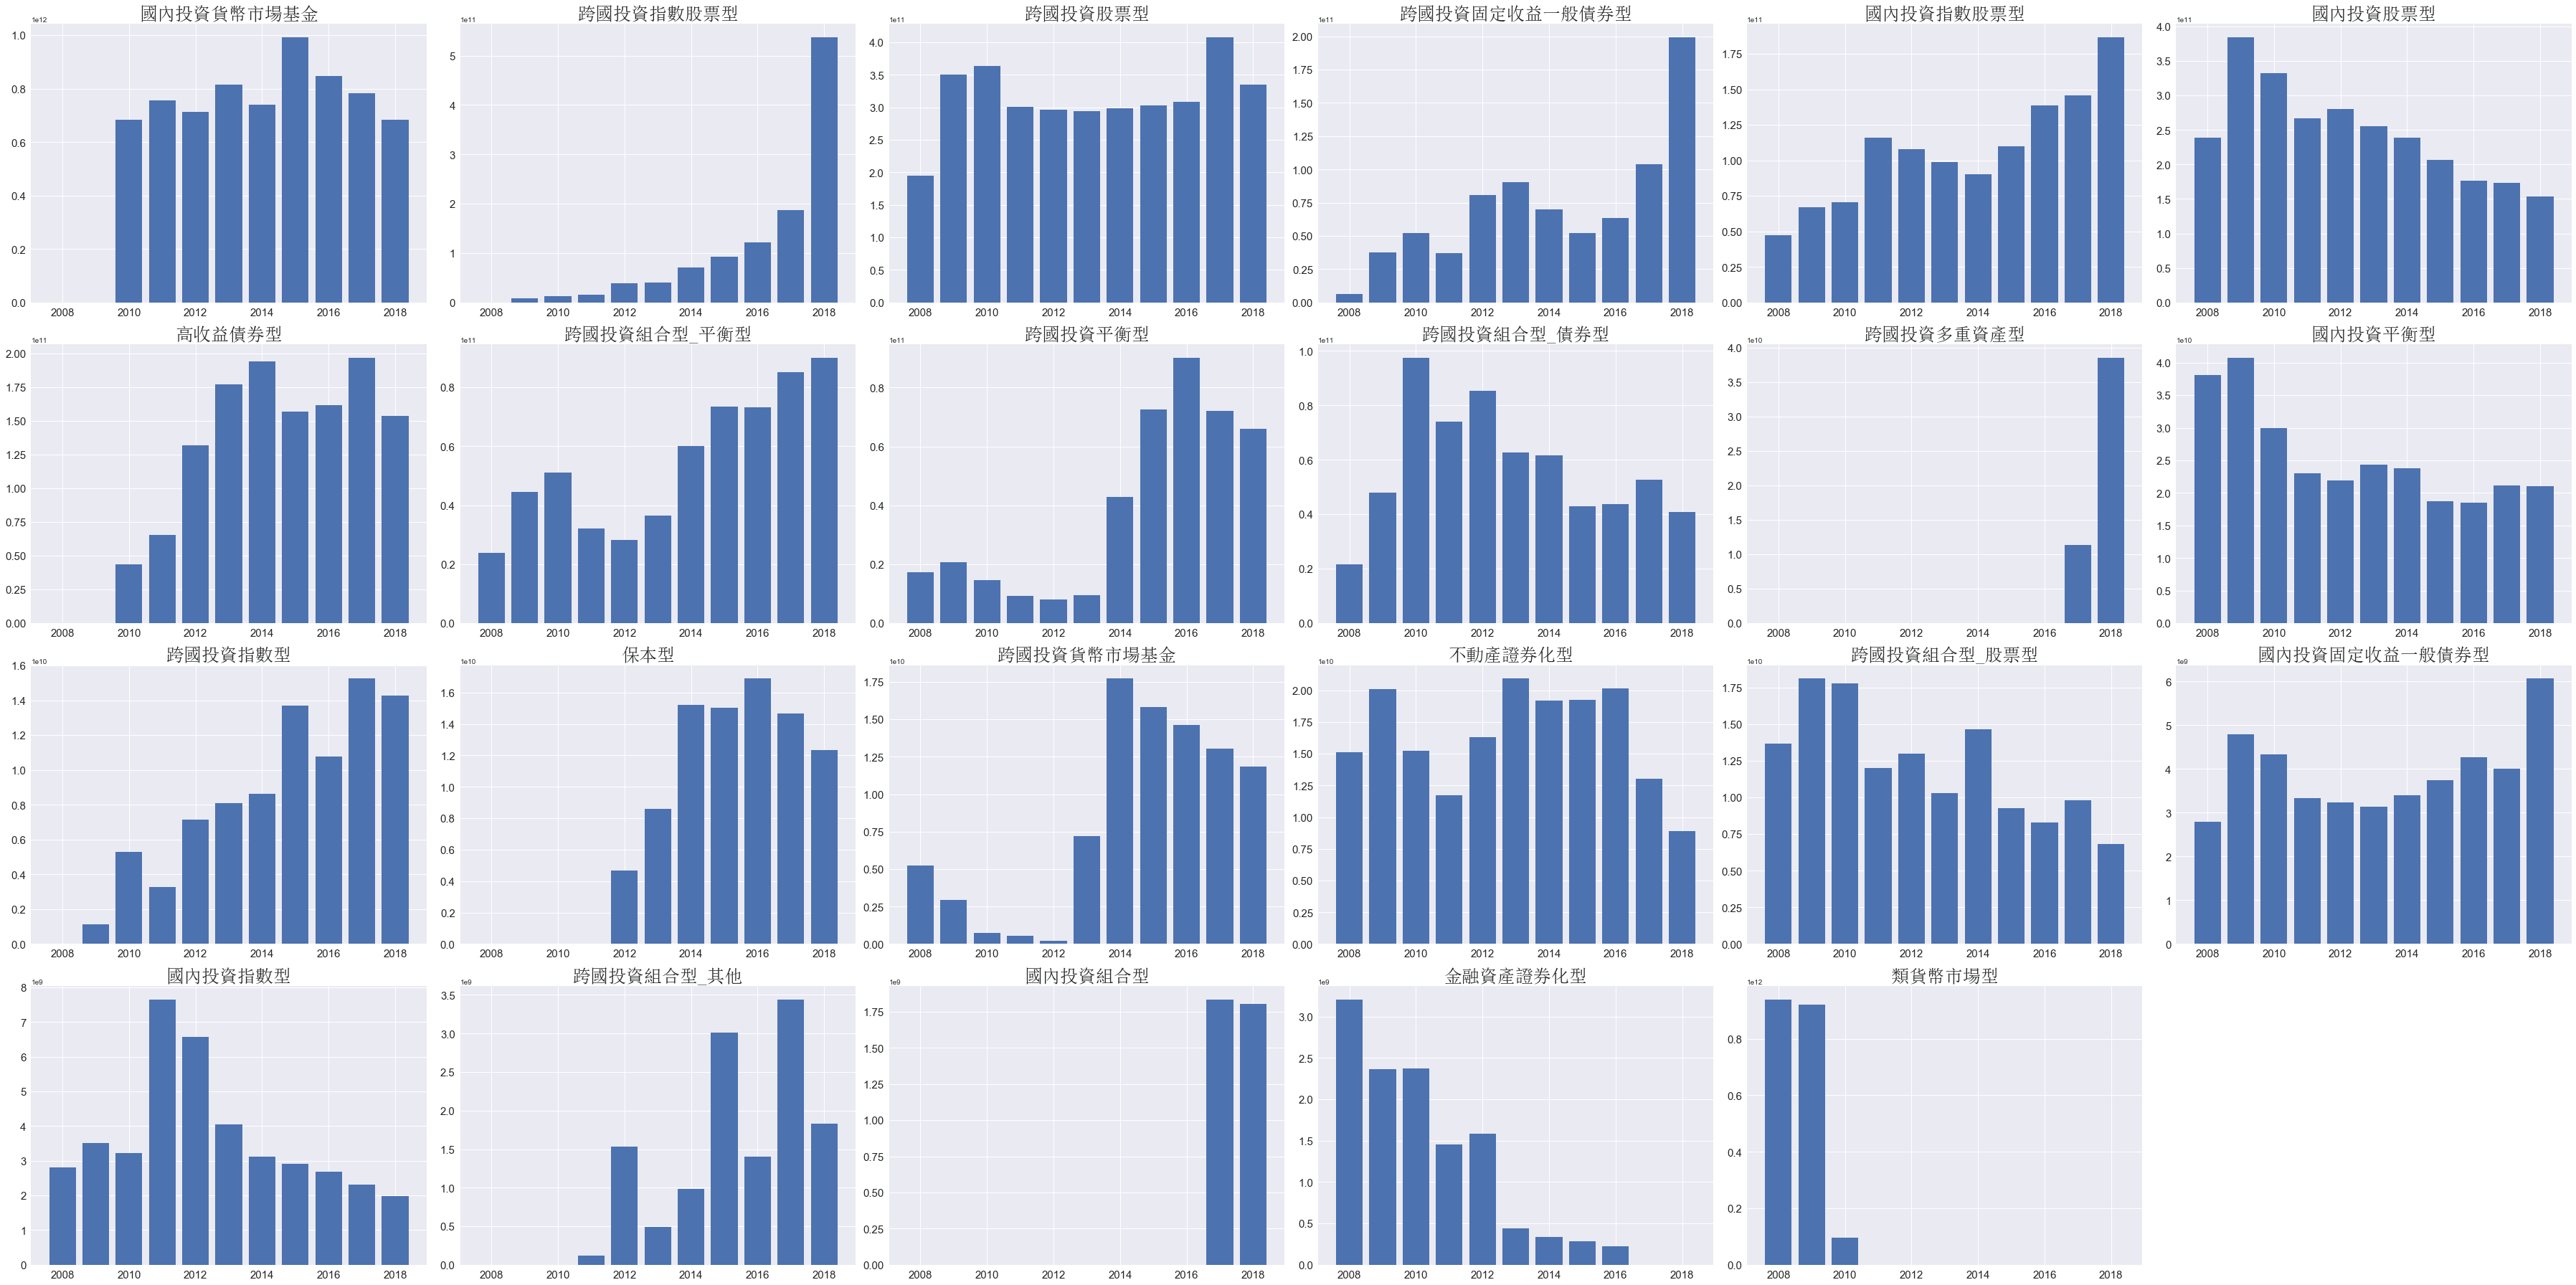

In [17]:
font = FontProperties(fname=r"c:\windows\Fonts\SimSun.ttc", size=25)

fig, axs = plt.subplots(4, 6, figsize=(50, 25))
axs = axs.ravel()

for i in range(len(category_order)):
    name = category_order.iloc[i]
    temp = groupby_category[groupby_category.類型代號 == name]
    temp.reset_index(inplace=True, drop=True)
    temp = temp.copy()
    temp['year'] = temp.年分.apply(lambda x: x.year)
    Y = []
    for ix in year_index:
        try:
            value = temp[temp.year == ix]['基金規模(台幣)'].values[0]
            if value != 0:
                Y.append(value)
            else:
                Y.append(0)
        except:
            Y.append(0)

    axs[i].bar(year_index, Y)
    axs[i].set_title(category_dict[name], FontProperties=font)
    plt.sca(axs[i])
    plt.xticks(size=15)
    plt.yticks(size=15)
    if i == len(category_order) - 1:
        fig.delaxes(axs[i+1])

    plt.tight_layout();

# 給定類別製圖

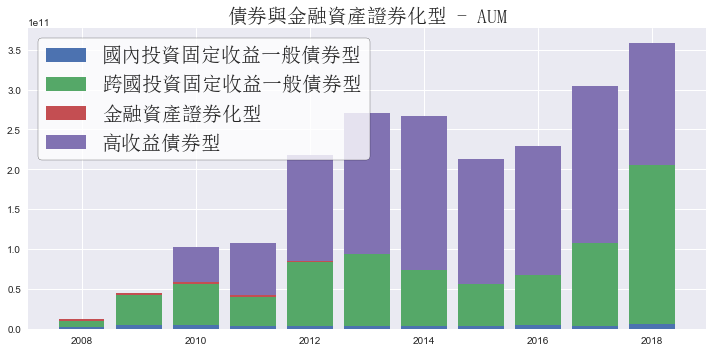

In [18]:
plt.figure(figsize=(10, 5))
font_legend = FontProperties(fname=r"c:\windows\Fonts\SimSun.ttc", size=20)

name = '債券與金融資產證券化型'    
target = data[data.大分類 == name]
target = target.groupby(['基金類型', '年分']).sum()
target.reset_index(inplace=True)
target = target[['基金類型', '年分', '基金規模(台幣)']]

cumulative_Y = np.array([0]*len(year_index))
for ixx in range(len(target.基金類型.unique())):
    fund = target.基金類型.unique()[ixx]
    temp_fund = target[target.基金類型 == fund]
    temp_fund = temp_fund.copy()
    temp_fund['year'] = temp_fund.年分.apply(lambda x: x.year)
    Y = []
    for ix in year_index:
        try:
            value = temp_fund[temp_fund.year == ix]['基金規模(台幣)'].values[0]
            if value != 0:
                Y.append(value)
            else:
                Y.append(0)
        except:
            Y.append(0)
    Y = np.array(Y)

    plt.bar(year_index, Y, bottom=cumulative_Y, label=fund)
    cumulative_Y = cumulative_Y + Y
    
legend = plt.legend(prop=font_legend, frameon=True, loc='upper left')
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('black')

font = FontProperties(fname=r"c:\windows\Fonts\SimSun.ttc", size=20)
plt.title(name+' - AUM', FontProperties=font)


plt.tight_layout();

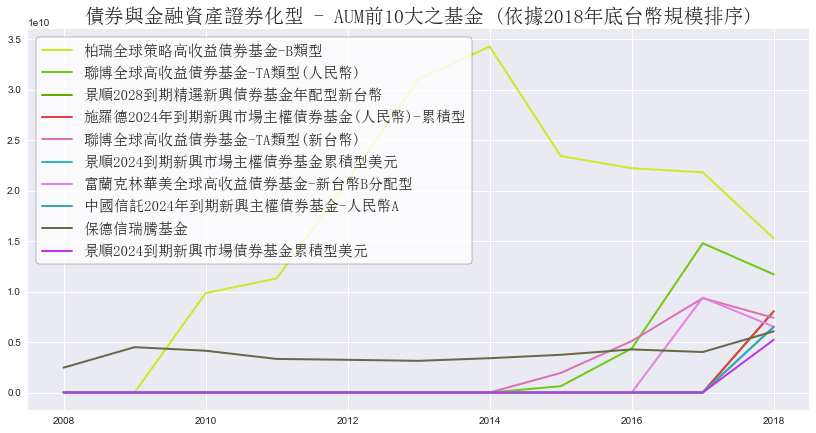

In [19]:
font_legend = FontProperties(fname=r"c:\windows\Fonts\SimSun.ttc", size=15)
font = FontProperties(fname=r"c:\windows\Fonts\SimSun.ttc", size=20)
plt.figure(figsize=(14, 7))

category_name = '債券與金融資產證券化型'
top_num = 10
temp = data[data.大分類 == category_name]
target_list = temp[temp.年分 == '2018/12/31'].sort_values('基金規模(台幣)', ascending=False).基金名稱.iloc[:top_num ]

for i in range(len(target_list)):
    name = target_list.iloc[i]
    target = data[data.基金名稱 == name]
    target.reset_index(inplace=True, drop=True)
    target = target.copy()
    target['year'] = target.年分.apply(lambda x: x.year)
    
    Y = []
    for ix in year_index:
        try:
            value = target[target.year == ix]['基金規模(台幣)'].values[0]
            if value != 0:
                Y.append(value)
            else:
                Y.append(0)
        except:
            Y.append(0)
    rgb = tuple(np.random.rand(3,1).ravel())
    plt.plot(year_index, Y, label=name, color=rgb, lw=2)
    legend = plt.legend(prop=font_legend, frameon=True, loc='upper left')
    frame = legend.get_frame()
    frame.set_facecolor('white')
    frame.set_edgecolor('black')
    plt.title(category_name+' - AUM前{}大之基金 (依據2018年底台幣規模排序)'.format(top_num), FontProperties=font)

# Reference
## coding
* subplot within for loop

  https://stackoverflow.com/questions/17210646/python-subplot-within-a-loop-first-panel-appears-in-wrong-position

* change scientific notation size

  https://stackoverflow.com/questions/34227595/how-to-change-font-size-of-the-scientific-notation-in-matplotlib

* change background  color of legend

  https://stackoverflow.com/questions/30729473/seaborn-legend-with-background-color/30736466

* random assign rgb color

  https://stackoverflow.com/questions/14720331/how-to-generate-random-colors-in-matplotlib

* delete subplot

  https://stackoverflow.com/questions/14694501/delete-a-subplot

* stacked barplot

  https://matplotlib.org/gallery/lines_bars_and_markers/bar_stacked.html

## data source
* 投信投顧公會

  https://www.sitca.org.tw/ROC/Industry/IN1001.aspx?PGMID=FD01#
* 境內境外規模比較

  https://www.sitca.org.tw/ROC/Industry/IN1001.aspx?PGMID=FD01
  
* 境內幣別

  https://www.sitca.org.tw/ROC/Industry/IN2001.aspx?PGMID=IN0201#
  
* 境外幣別

  https://www.sitca.org.tw/ROC/Industry/IN3001.aspx?PGMID=IN0301#

* 富達Multi asset流出多

  https://www.fidelity.com.tw/insights-learning/weekly_fund_flow_0325.html

# Note
* AI, AH不存在於類別中(因年份編碼問題)
* 組合型為fund of fund
* 全權委託的資料沒有各資產類別，只有委託對象

  (https://www.sitca.org.tw/ROC/Industry/IN4001.aspx?PGMID=IN0401&PORDER=5&pYEAR=2017&pMONTH=09#)